# Imports

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#model`s stuff
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose # identify seasonal component
import pmdarima as pm
import pickle

# DataFrame formation

In [2]:
gvs_time_series = pd.read_excel("Посуточная ведомость ОДПУ ГВС.xlsx", header=0)
hvs_time_series = pd.read_excel("Посуточная ведомость водосчетчика ХВС ИТП.xlsx", header=0)

In [3]:
gvs_time_series

,Дата,"Время суток, ч","Подача, м3","Обратка, м3","Потребление за период, м3","Т1 гвс, оС","Т2 гвс, оС"
0,01.04.2025,0-1,0.23,0.12,0.11,60,42
1,01.04.2025,1-2,0.09,0.05,0.04,60,42
2,01.04.2025,2-3,0.11,0.06,0.05,60,42
3,01.04.2025,3-4,0.11,0.06,0.05,60,42
4,01.04.2025,4-5,0.14,0.08,0.06,60,42
...,...,...,...,...,...,...,...
715,2025-04-30 00:00:00,19-20,0.00,0.00,0.00,48,27
716,2025-04-30 00:00:00,20-21,0.00,0.00,0.00,48,27
717,2025-04-30 00:00:00,21-22,0.00,0.00,0.00,48,27
718,2025-04-30 00:00:00,22-23,0.00,0.00,0.00,48,27


In [4]:
hvs_time_series = hvs_time_series.rename(columns={'Потребление за период, м3': 'ХВС Потребление за период, м3'})
gvs_time_series = pd.concat([gvs_time_series, hvs_time_series[['ХВС Потребление за период, м3']]], axis=1) # формирование датафрейма со всемаи показаниями

In [5]:
gvs_time_series['Дата'] = pd.to_datetime(gvs_time_series['Дата'], format='%d.%m.%Y', errors='coerce')

hour = gvs_time_series['Время суток, ч'].str.split('-').str[0].astype(int)

gvs_time_series['Метка времени'] = gvs_time_series['Дата'] + pd.to_timedelta(hour, unit='h')#  получение метки времени(в excel оно некорректное)

In [6]:
print(gvs_time_series.isnull().sum())# проверка на null

Дата                             0
Время суток, ч                   0
Подача, м3                       0
Обратка, м3                      0
Потребление за период, м3        0
Т1 гвс, оС                       0
Т2 гвс, оС                       0
ХВС Потребление за период, м3    0
Метка времени                    0
dtype: int64


In [7]:
gvs_time_series.set_index('Метка времени', inplace=True)# устанавливаем индекс на метку времени
gvs_time_series = gvs_time_series.loc[:'2025-04-27 00:00:00']# не учитываем нлевые показания

# Scaling

In [8]:
#from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#gvs_time_series[['Подача, м3']] = scaler.fit_transform(gvs_time_series[['Подача, м3']])

In [9]:
# избавляемся от нулевых значений
gvs_time_series['Подача, м3'] = gvs_time_series['Подача, м3'].replace(0.00, 0.01)
gvs_time_series['Обратка, м3'] = gvs_time_series['Обратка, м3'].replace(0.00, 0.01)
gvs_time_series['ХВС Потребление за период, м3'] = gvs_time_series['ХВС Потребление за период, м3'].replace(0.00, 0.01)

# Exogenous variable

In [10]:
gvs_time_series['hour_index'] = gvs_time_series.index.hour # указываем индекс часа как экзогенную переменную

In [11]:
gvs_time_series

,Дата,"Время суток, ч","Подача, м3","Обратка, м3","Потребление за период, м3","Т1 гвс, оС","Т2 гвс, оС","ХВС Потребление за период, м3",hour_index
Метка времени,,,,,,,,,
2025-04-01 00:00:00,2025-04-01,0-1,0.23,0.12,0.11,60,42,0.11,0
2025-04-01 01:00:00,2025-04-01,1-2,0.09,0.05,0.04,60,42,0.04,1
2025-04-01 02:00:00,2025-04-01,2-3,0.11,0.06,0.05,60,42,0.05,2
2025-04-01 03:00:00,2025-04-01,3-4,0.11,0.06,0.05,60,42,0.05,3
2025-04-01 04:00:00,2025-04-01,4-5,0.14,0.08,0.06,60,42,0.06,4
...,...,...,...,...,...,...,...,...,...
2025-04-26 20:00:00,2025-04-26,20-21,0.08,0.05,0.03,52,31,0.28,20
2025-04-26 21:00:00,2025-04-26,21-22,0.07,0.04,0.03,52,31,0.24,21
2025-04-26 22:00:00,2025-04-26,22-23,0.06,0.04,0.02,52,31,0.20,22


# Identify Seasonal Component

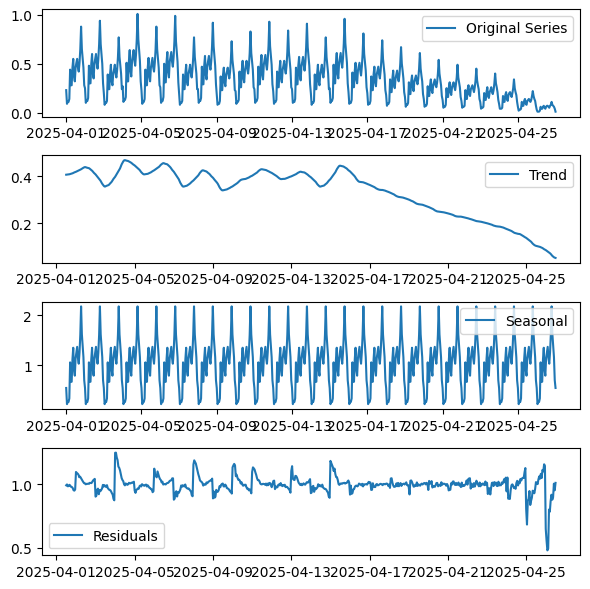

In [12]:
data_type = 'Подача, м3'# анализируем тренды и сезонность данных
#data_type = 'Обратка, м3'
#data_type = 'ХВС Потребление за период, м3	'

result = seasonal_decompose(gvs_time_series[data_type], model='multiplicative', period=24)# расскладываем компоненты 
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()

# Строим график разложенных компонентов
plt.figure(figsize=(6,6))

plt.subplot(4, 1, 1)
plt.plot(gvs_time_series[data_type], label='Original Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()

#  SARIMAX Model Fitting

In [13]:
warnings.filterwarnings("ignore")# игнорируем FutureWarnings и другие предупреждения

In [ ]:
SARIMAX_model = pm.auto_arima(
    gvs_time_series[['Подача, м3']],          # целевая переменная
    exogenous=gvs_time_series[['hour_index']], # экзогенные переменные
    
    # Параметры НЕсезонной части модели (p, d, q)
    start_p=1,  # начальное значение порядка авторегрессии (AR) - сколько прошлых значений использовать
    start_q=1,  # начальное значение порядка скользящего среднего (MA) - сколько прошлых ошибок использовать
    
    # Определение порядка интегрирования (d)
    test='adf', # тест Дики-Фуллера для автоматического определения параметра d
                # d отвечает за количество дифференцирований для стационарности ряда
    
    # Ограничения для перебора параметров
    max_p=3,    # максимальный порядок авторегрессии (AR)
    max_q=3,    # максимальный порядок скользящего среднего (MA)
    m=24,       # период сезонности - 24 часа
    
    # Параметры СЕЗОННОЙ части модели (P, D, Q, m)
    start_P=0,      # начальное значение сезонного порядка авторегрессии
    seasonal=True,  # включить сезонную компоненту
    
    # Определение порядков дифференцирования
    d=None,     # автоматически определить порядок несезонного дифференцирования
    D=1,        # фиксированный порядок сезонного дифференцирования = 1
    
    # Настройки процесса подбора
    trace=False,            # не выводить подробный процесс подбора
    error_action='ignore',  # игнорировать ошибки при невалидных комбинациях параметров
    suppress_warnings=True, # подавить предупреждения
    stepwise=True          # использовать эффективный stepwise алгоритм вместо полного перебора
)

In [ ]:
SARIMAX_model.summary() # вывод информации о модели с автоматически подобранными параметрами

# Forecasting 

## ГВС Подача

In [33]:
# СОЗДАНИЕ МОДЕЛИ SARIMAX С ПАРАМЕТРАМИ ОТ AUTO-ARIMA
model_gvs_podacha = SARIMAX(
    # Целевая переменная
    gvs_time_series['Подача, м3'], 
    
    # НЕСЕЗОННЫЕ ПАРАМЕТРЫ (p, d, q) - от auto_arima
    order = (1, 0, 0), 
    # p=1 - авторегрессия 1-го порядка (используется 1 предыдущее значение)
    # d=0 - НЕТ дифференцирования (ряд уже стационарен)
    # q=0 - НЕТ скользящего среднего (не используются прошлые ошибки)
    
    # СЕЗОННЫЕ ПАРАМЕТРЫ (P, D, Q, s) - от auto_arima  
    seasonal_order = (2, 1, 1, 24)
    # P=2 - сезонная авторегрессия 2-го порядка (используются значения 24 и 48 часов назад)
    # D=1 - сезонное дифференцирование 1-го порядка (ряд дифференцируется с лагом 24 часа)
    # Q=1 - сезонное скользящее среднее 1-го порядка (используется ошибка 24 часа назад)
    # s=24 - период сезонности = 24 часа (суточный цикл)
)

result1 = model_gvs_podacha.fit()
# Процесс обучения:
# 1. Модель находит оптимальные значения коэффициентов для параметров AR, MA, SAR, SMA
# 2. Используется метод максимального правдоподобия (MLE)
# 3. Происходит оптимизация функции правдоподобия

# ВЫВОД СТАТИСТИЧЕСКОЙ СВОДКИ МОДЕЛИ
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           Подача, м3   No. Observations:                  625
Model:             SARIMAX(1, 0, 0)x(2, 1, [1], 24)   Log Likelihood                1608.167
Date:                              Thu, 02 Oct 2025   AIC                          -3206.335
Time:                                      23:25:50   BIC                          -3184.342
Sample:                                  04-01-2025   HQIC                         -3197.774
                                       - 04-27-2025                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9357      0.009     99.220      0.000       0.917       0.954
ar.S.L24       0.2080      0.044      4.712      0.000       0.121       0.295
ar.S.L48       0.7174      0.027     26.271      0.000       0.664       0.771
ma.S.L24      -0.7876      0.072    -10.966      0.000      -0.928      -0.647
sigma2         0.0003   1.17e-05     22.427      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               333.45
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
# Создаем словарь со всей необходимой информацией
model_package = {
    'model': result1,
    'model_type': 'SARIMAX',
    'order': (1, 0, 0),
    'seasonal_order': (2, 1, 1, 24),
    'training_data_info': {
        'series_name': 'Подача, м3',
        'data_length': len(gvs_time_series),
        'last_date': gvs_time_series.index[-1] if hasattr(gvs_time_series.index, '[-1]') else None
    },
    'fit_date': pd.Timestamp.now()
}

# Сохраняем полный пакет
with open('sarimax_model_gvs_podacha.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("Полный пакет модели сохранен в sarimax_model_gvs_podacha.pkl")

Полный пакет модели сохранен в sarimax_model_gvs_podacha.pkl


In [35]:
# Загрузка модели из pickle файла
with open('sarimax_model_gvs_podacha.pkl', 'rb') as f:
    loaded_package = pickle.load(f)

# Извлекаем компоненты из пакета
model_gvs_podacha = loaded_package['model']
model_type = loaded_package['model_type']
order = loaded_package['order']
seasonal_order = loaded_package['seasonal_order']
training_info = loaded_package['training_data_info']
fit_date = loaded_package['fit_date']

print("Модель успешно загружена!")
print(f"Тип модели: {model_type}")
print(f"Order: {order}")
print(f"Seasonal order: {seasonal_order}")
print(f"Дата обучения: {fit_date}")
print(f"Тип данных: {training_info}")

Модель успешно загружена!
Тип модели: SARIMAX
Order: (1, 0, 0)
Seasonal order: (2, 1, 1, 24)
Дата обучения: 2025-10-02 23:25:50.314532
Тип данных: {'series_name': 'Подача, м3', 'data_length': 625, 'last_date': None}


In [38]:
# ДИНАМИЧЕСКИЙ ПРОГНОЗ НА ИСТОРИЧЕСКИХ ДАННЫХ (начиная с 20 апреля)
dyn_pred_gvs_podacha = model_gvs_podacha.get_prediction(
    start=pd.to_datetime('2025-04-20 00:00:00'),  # Начало прогноза
    dynamic=True  # ДИНАМИЧЕСКИЙ режим: каждый следующий прогноз использует предыдущие прогнозы
) 
# Получаем предсказанные значения
dynamic_pred_values_gvs_podacha = dyn_pred_gvs_podacha.predicted_mean

# Фактические значения для сравнения (с 16 апреля для более длинного периода)
actual_values = gvs_time_series['2025-04-16 00:00:00':]['Подача, м3']

# ВЫЧИСЛЕНИЕ СРЕДНЕКВАДРАТИЧНОЙ ОШИБКИ (MSE)
dyn_pred_gvs_podacha_mse = ((dynamic_pred_values_gvs_podacha - actual_values) ** 2).mean()
print('Среднеквадратичная ошибка прогноза составляет {}'.format(round(dyn_pred_gvs_podacha_mse, 2)))

# ПРОГНОЗ НА БУДУЩЕЕ (72 часа = 3 суток)
dynamic_forecast_gvs_podacha = model_gvs_podacha.get_forecast(steps=24)
dynamic_forecast_values_gvs_podacha = dynamic_forecast_gvs_podacha.predicted_mean

Среднеквадратичная ошибка прогноза составляет 0.01


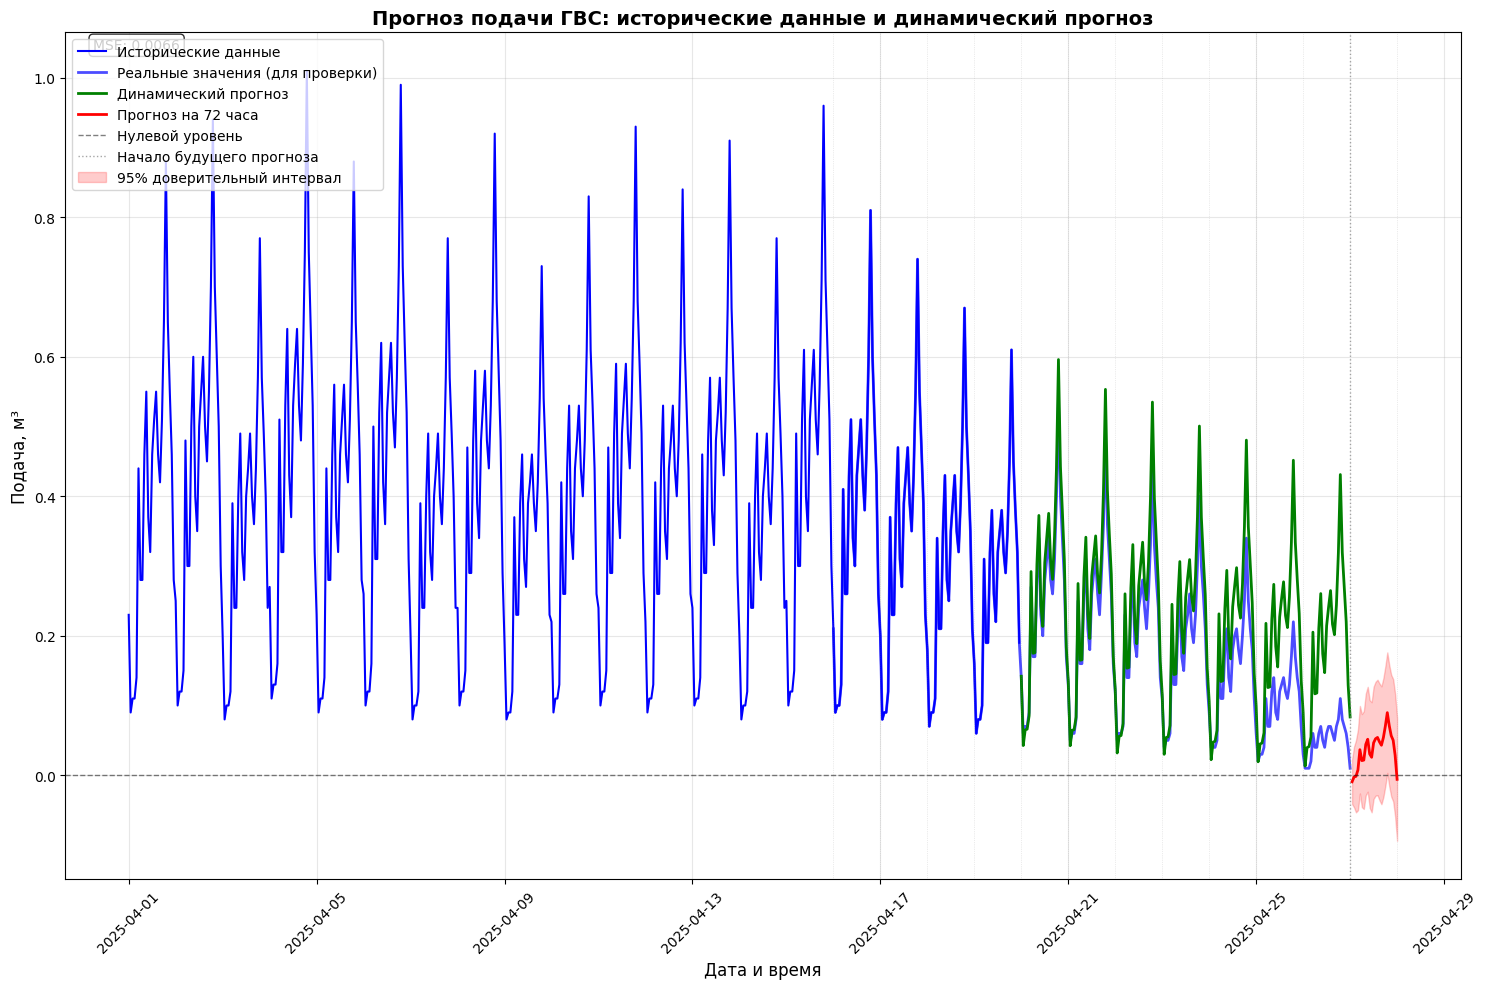


📊 ДЕТАЛИ ПРОГНОЗА:
   • Период валидации: 2025-04-16 00:00:00 - 2025-04-27 00:00:00
   • Начало прогноза: 2025-04-20 00:00:00
   • Будущий прогноз: 2025-04-27 01:00:00 - 2025-04-28 00:00:00
   • MSE: 0.0066

📈 ПЕРВЫЕ 10 ЗНАЧЕНИЙ ПРОГНОЗА:
   2025-04-27 01:00: -0.009 м³
   2025-04-27 02:00: -0.003 м³
   2025-04-27 03:00: -0.002 м³
   2025-04-27 04:00: 0.008 м³
   2025-04-27 05:00: 0.037 м³
   2025-04-27 06:00: 0.021 м³
   2025-04-27 07:00: 0.022 м³
   2025-04-27 08:00: 0.044 м³
   2025-04-27 09:00: 0.052 м³
   2025-04-27 10:00: 0.030 м³


In [39]:
# ПОСТРОЕНИЕ ГРАФИКА
plt.figure(figsize=(15, 10))

# 1. ИСТОРИЧЕСКИЕ ДАННЫЕ (до начала прогноза)
historical_data = gvs_time_series[:'2025-04-19 23:00:00']['Подача, м3']
plt.plot(historical_data.index, historical_data, 
         label='Исторические данные', color='blue', linewidth=1.5)

# 2. РЕАЛЬНЫЕ ЗНАЧЕНИЯ (период валидации)
plt.plot(actual_values.index, actual_values, 
         label='Реальные значения (для проверки)', color='blue', linewidth=2, alpha=0.7)

# 3. ДИНАМИЧЕСКИЙ ПРОГНОЗ НА ИСТОРИЧЕСКИХ ДАННЫХ
plt.plot(dynamic_pred_values_gvs_podacha.index, dynamic_pred_values_gvs_podacha, 
         label='Динамический прогноз', color='green', linewidth=2, linestyle='-')

# 4. ПРОГНОЗ НА БУДУЩЕЕ
future_dates = pd.date_range(start=actual_values.index[-1] + pd.Timedelta(hours=1), 
                            periods=24, freq='H')
plt.plot(future_dates, dynamic_forecast_values_gvs_podacha, 
         label='Прогноз на 72 часа', color='red', linewidth=2)

# 5. НУЛЕВАЯ ЛИНИЯ
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Нулевой уровень')

# 6. ЛИНИЯ РАЗДЕЛЕНИЯ МЕЖДУ ИСТОРИЕЙ И ПРОГНОЗОМ
split_date = actual_values.index[-1]
plt.axvline(x=split_date, color='gray', linestyle=':', linewidth=1, alpha=0.7, 
           label='Начало будущего прогноза')

# 7. ОБЛАСТЬ ДОВЕРИТЕЛЬНОГО ИНТЕРВАЛА (если есть)
try:
    conf_int = dynamic_forecast_gvs_podacha.conf_int()
    plt.fill_between(future_dates, 
                    conf_int.iloc[:, 0], 
                    conf_int.iloc[:, 1], 
                    color='red', alpha=0.2, 
                    label='95% доверительный интервал')
except:
    print("Доверительные интервалы недоступны")

# НАСТРОЙКА ГРАФИКА
plt.title('Прогноз подачи ГВС: исторические данные и динамический прогноз', 
          fontsize=14, fontweight='bold')
plt.xlabel('Дата и время', fontsize=12)
plt.ylabel('Подача, м³', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)

# ВЕРТИКАЛЬНЫЕ ЛИНИИ ДЛЯ РАЗДЕЛЕНИЯ СУТОК
for date in pd.date_range(start='2025-04-16', end=future_dates[-1], freq='D'):
    plt.axvline(x=date, color='gray', linestyle=':', linewidth=0.5, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()

# ДОБАВЛЕНИЕ ТЕКСТОВОЙ ИНФОРМАЦИИ НА ГРАФИК
plt.text(0.02, 0.98, f'MSE: {dyn_pred_gvs_podacha_mse:.4f}', 
         transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.show()


# ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ
print(f"\n📊 ДЕТАЛИ ПРОГНОЗА:")
print(f"   • Период валидации: {actual_values.index[0]} - {actual_values.index[-1]}")
print(f"   • Начало прогноза: {dynamic_pred_values_gvs_podacha.index[0]}")
print(f"   • Будущий прогноз: {future_dates[0]} - {future_dates[-1]}")
print(f"   • MSE: {dyn_pred_gvs_podacha_mse:.4f}")

# ВЫВОД ПЕРВЫХ 10 ЗНАЧЕНИЙ ПРОГНОЗА
print(f"\n📈 ПЕРВЫЕ 10 ЗНАЧЕНИЙ ПРОГНОЗА:")
for i, (date, value) in enumerate(zip(future_dates[:10], dynamic_forecast_values_gvs_podacha[:10])):
    print(f"   {date.strftime('%Y-%m-%d %H:%M')}: {value:.3f} м³")

## ГВС Обратка

In [ ]:
# Аналогичные действия с обучением модели для Подачи
SARIMAX_model_gvs_obratka = pm.auto_arima(gvs_time_series[['Обратка, м3']], exogenous=gvs_time_series[['hour_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, seasonal=True,
                           d=None, D=1,
                           trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

In [ ]:
SARIMAX_model_gvs_obratka.summary()

In [ ]:
# Аналогичные действия с обучением модели для Подачи
model_gvs_obratka = SARIMAX(gvs_time_series['Обратка, м3'], 
                order = (1, 0, 0), 
                seasonal_order =(1, 1, [1, 2], 24))

result2 = model_gvs_obratka.fit()
result2.summary()

In [ ]:
import pickle

# Создаем словарь со всей необходимой информацией
model_package = {
    'model': result2,
    'model_type': 'SARIMAX',
    'order': (1, 0, 0),
    'seasonal_order': (2, 1, 1, 24),
    'training_data_info': {
        'series_name': 'Обратка, м3',
        'data_length': len(gvs_time_series),
        'last_date': gvs_time_series.index[-1] if hasattr(gvs_time_series.index, '[-1]') else None
    },
    'fit_date': pd.Timestamp.now()
}

# Сохраняем полный пакет
with open('sarimax_model_gvs_obratka.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("Полный пакет модели сохранен в sarimax_model_gvs_obratka.pkl")

In [16]:
# Загрузка модели из pickle файла
with open('sarimax_model_gvs_obratka.pkl', 'rb') as f:
    loaded_package = pickle.load(f)

# Извлекаем компоненты из пакета
model_gvs_obratka = loaded_package['model']
model_type = loaded_package['model_type']
order = loaded_package['order']
seasonal_order = loaded_package['seasonal_order']
training_info = loaded_package['training_data_info']
fit_date = loaded_package['fit_date']

print("Модель успешно загружена!")
print(f"Тип модели: {model_type}")
print(f"Order: {order}")
print(f"Seasonal order: {seasonal_order}")
print(f"Дата обучения: {fit_date}")
print(f"Тип данных: {training_info}")

Модель успешно загружена!
Тип модели: SARIMAX
Order: (1, 0, 0)
Seasonal order: (2, 1, 1, 24)
Дата обучения: 2025-10-01 23:34:43.044294
Тип данных: {'series_name': 'Обратка, м3', 'data_length': 625, 'last_date': None}


In [17]:
# ДИНАМИЧЕСКИЙ ПРОГНОЗ НА ИСТОРИЧЕСКИХ ДАННЫХ (начиная с 20 апреля)
dyn_pred_gvs_obratka = model_gvs_obratka.get_prediction(
    start=pd.to_datetime('2025-04-20 00:00:00'),  # Начало прогноза
    dynamic=True  # ДИНАМИЧЕСКИЙ режим: каждый следующий прогноз использует предыдущие прогнозы
) 
# Получаем предсказанные значения
dynamic_pred_values_gvs_obratka = dyn_pred_gvs_obratka.predicted_mean

# Фактические значения для сравнения (с 16 апреля для более длинного периода)
actual_values = gvs_time_series['2025-04-16 00:00:00':]['Обратка, м3']

# ВЫЧИСЛЕНИЕ СРЕДНЕКВАДРАТИЧНОЙ ОШИБКИ (MSE)
dyn_pred_gvs_obratka_mse = ((dynamic_pred_values_gvs_obratka - actual_values) ** 2).mean()
print('Среднеквадратичная ошибка прогноза составляет {}'.format(round(dyn_pred_gvs_obratka_mse, 2)))

# ПРОГНОЗ НА БУДУЩЕЕ (72 часа = 3 суток)
dynamic_forecast_gvs_obratka = model_gvs_obratka.get_forecast(steps=72)
dynamic_forecast_values_gvs_obratka = dynamic_forecast_gvs_obratka.predicted_mean

Среднеквадратичная ошибка прогноза составляет 0.01


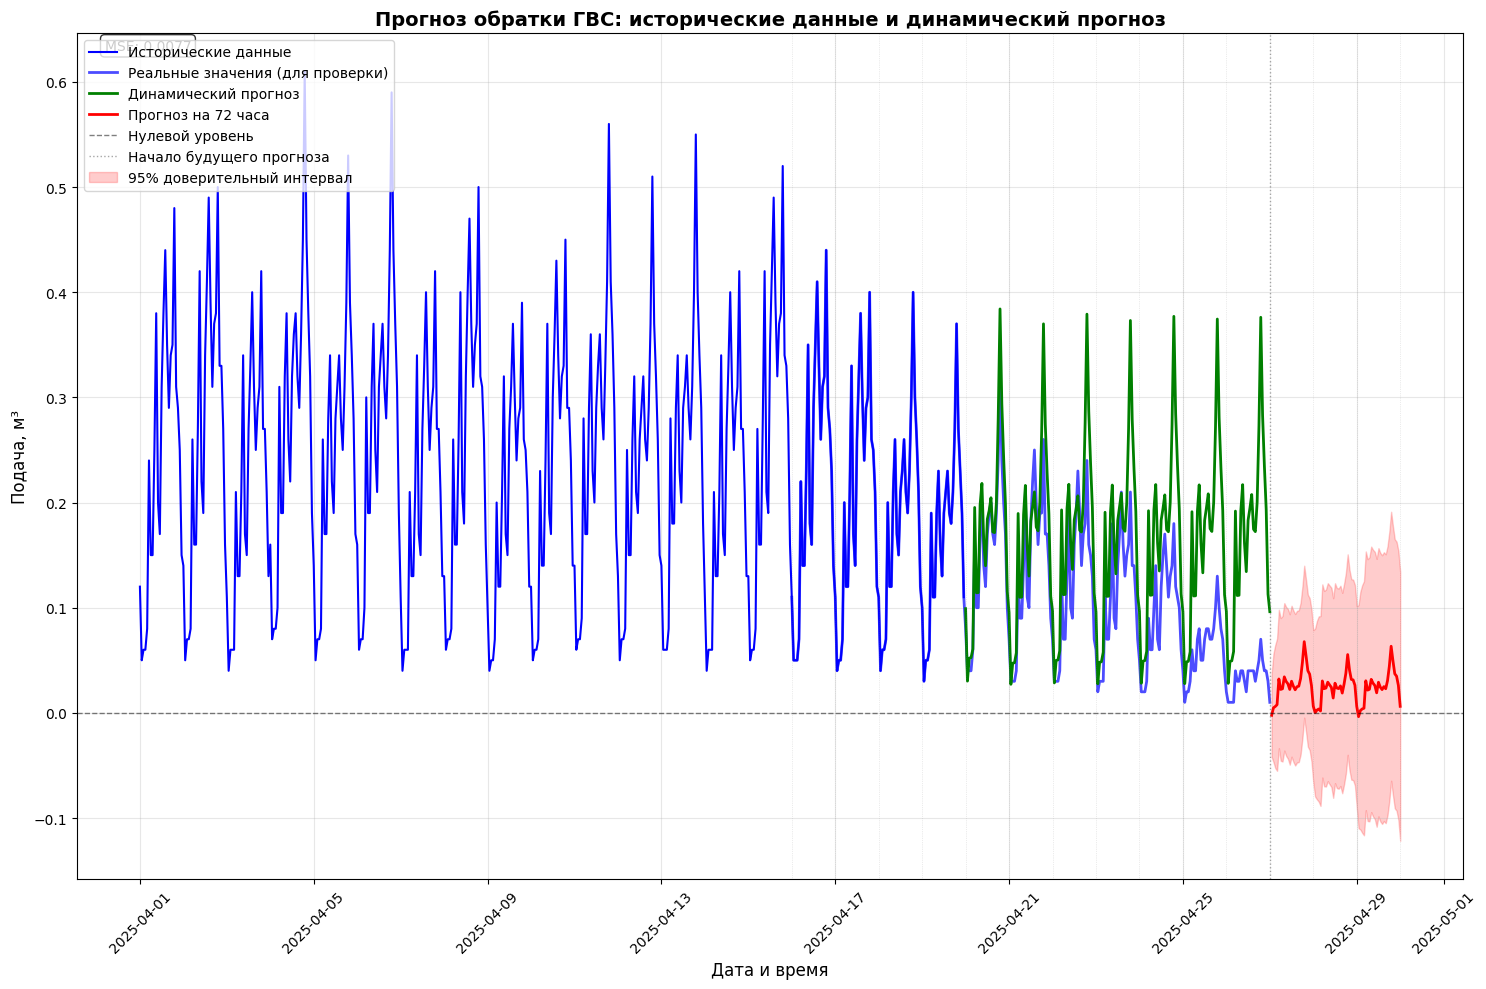


📊 ДЕТАЛИ ПРОГНОЗА:
   • Период валидации: 2025-04-16 00:00:00 - 2025-04-27 00:00:00
   • Начало прогноза: 2025-04-20 00:00:00
   • Будущий прогноз: 2025-04-27 01:00:00 - 2025-04-30 00:00:00
   • MSE: 0.0077

📈 ПЕРВЫЕ 10 ЗНАЧЕНИЙ ПРОГНОЗА:
   2025-04-27 01:00: -0.002 м³
   2025-04-27 02:00: 0.005 м³
   2025-04-27 03:00: 0.006 м³
   2025-04-27 04:00: 0.008 м³
   2025-04-27 05:00: 0.032 м³
   2025-04-27 06:00: 0.022 м³
   2025-04-27 07:00: 0.023 м³
   2025-04-27 08:00: 0.034 м³
   2025-04-27 09:00: 0.030 м³
   2025-04-27 10:00: 0.028 м³


In [18]:
# ПОСТРОЕНИЕ ГРАФИКА
plt.figure(figsize=(15, 10))

# 1. ИСТОРИЧЕСКИЕ ДАННЫЕ (до начала прогноза)
historical_data = gvs_time_series[:'2025-04-19 23:00:00']['Обратка, м3']
plt.plot(historical_data.index, historical_data, 
         label='Исторические данные', color='blue', linewidth=1.5)

# 2. РЕАЛЬНЫЕ ЗНАЧЕНИЯ (период валидации)
plt.plot(actual_values.index, actual_values, 
         label='Реальные значения (для проверки)', color='blue', linewidth=2, alpha=0.7)

# 3. ДИНАМИЧЕСКИЙ ПРОГНОЗ НА ИСТОРИЧЕСКИХ ДАННЫХ
plt.plot(dynamic_pred_values_gvs_obratka.index, dynamic_pred_values_gvs_obratka, 
         label='Динамический прогноз', color='green', linewidth=2, linestyle='-')

# 4. ПРОГНОЗ НА БУДУЩЕЕ
future_dates = pd.date_range(start=actual_values.index[-1] + pd.Timedelta(hours=1), 
                            periods=72, freq='H')
plt.plot(future_dates, dynamic_forecast_values_gvs_obratka, 
         label='Прогноз на 72 часа', color='red', linewidth=2)

# 5. НУЛЕВАЯ ЛИНИЯ
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Нулевой уровень')

# 6. ЛИНИЯ РАЗДЕЛЕНИЯ МЕЖДУ ИСТОРИЕЙ И ПРОГНОЗОМ
split_date = actual_values.index[-1]
plt.axvline(x=split_date, color='gray', linestyle=':', linewidth=1, alpha=0.7, 
           label='Начало будущего прогноза')

# 7. ОБЛАСТЬ ДОВЕРИТЕЛЬНОГО ИНТЕРВАЛА (если есть)
try:
    conf_int = dynamic_forecast_gvs_obratka.conf_int()
    plt.fill_between(future_dates, 
                    conf_int.iloc[:, 0], 
                    conf_int.iloc[:, 1], 
                    color='red', alpha=0.2, 
                    label='95% доверительный интервал')
except:
    print("Доверительные интервалы недоступны")

# НАСТРОЙКА ГРАФИКА
plt.title('Прогноз обратки ГВС: исторические данные и динамический прогноз', 
          fontsize=14, fontweight='bold')
plt.xlabel('Дата и время', fontsize=12)
plt.ylabel('Подача, м³', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)

# ВЕРТИКАЛЬНЫЕ ЛИНИИ ДЛЯ РАЗДЕЛЕНИЯ СУТОК
for date in pd.date_range(start='2025-04-16', end=future_dates[-1], freq='D'):
    plt.axvline(x=date, color='gray', linestyle=':', linewidth=0.5, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()

# ДОБАВЛЕНИЕ ТЕКСТОВОЙ ИНФОРМАЦИИ НА ГРАФИК
plt.text(0.02, 0.98, f'MSE: {dyn_pred_gvs_obratka_mse:.4f}', 
         transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.show()


# ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ
print(f"\n📊 ДЕТАЛИ ПРОГНОЗА:")
print(f"   • Период валидации: {actual_values.index[0]} - {actual_values.index[-1]}")
print(f"   • Начало прогноза: {dynamic_pred_values_gvs_obratka.index[0]}")
print(f"   • Будущий прогноз: {future_dates[0]} - {future_dates[-1]}")
print(f"   • MSE: {dyn_pred_gvs_obratka_mse:.4f}")

# ВЫВОД ПЕРВЫХ 10 ЗНАЧЕНИЙ ПРОГНОЗА
print(f"\n📈 ПЕРВЫЕ 10 ЗНАЧЕНИЙ ПРОГНОЗА:")
for i, (date, value) in enumerate(zip(future_dates[:10], dynamic_forecast_values_gvs_obratka[:10])):
    print(f"   {date.strftime('%Y-%m-%d %H:%M')}: {value:.3f} м³")

## ХВС Потребление

In [ ]:
SARIMAX_model_hvs_potreb = pm.auto_arima(gvs_time_series[['ХВС Потребление за период, м3']], exogenous=gvs_time_series[['hour_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, seasonal=True,
                           d=None, D=1,
                           trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

In [ ]:
SARIMAX_model_hvs_potreb.summary()

In [ ]:
SARIMAX_model_hvs_potreb = SARIMAX(gvs_time_series['ХВС Потребление за период, м3'], 
                order = (1, 0, 2), 
                seasonal_order =(1, 1, 2, 24))

result3 = SARIMAX_model_hvs_potreb.fit()
result3.summary()

In [ ]:
model_package = {
    'model': result3,
    'model_type': 'SARIMAX',
    'order': (1, 0, 0),
    'seasonal_order': (2, 1, 1, 24),
    'training_data_info': {
        'series_name': 'ХВС Потребление за период, м3',
        'data_length': len(gvs_time_series),
        'last_date': gvs_time_series.index[-1] if hasattr(gvs_time_series.index, '[-1]') else None
    },
    'fit_date': pd.Timestamp.now()
}

# Сохраняем полный пакет
with open('sarimax_model_hvs_potreb.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("Полный пакет модели сохранен в sarimax_model_hvs_potreb.pkl")

In [19]:
# Загрузка модели из pickle файла
with open('sarimax_model_hvs_potreb.pkl', 'rb') as f:
    loaded_package = pickle.load(f)

# Извлекаем компоненты из пакета
model_hvs_potreb = loaded_package['model']
model_type = loaded_package['model_type']
order = loaded_package['order']
seasonal_order = loaded_package['seasonal_order']
training_info = loaded_package['training_data_info']
fit_date = loaded_package['fit_date']

print("Модель успешно загружена!")
print(f"Тип модели: {model_type}")
print(f"Order: {order}")
print(f"Seasonal order: {seasonal_order}")
print(f"Дата обучения: {fit_date}")
print(f"Тип данных: {training_info}")

Модель успешно загружена!
Тип модели: SARIMAX
Order: (1, 0, 0)
Seasonal order: (2, 1, 1, 24)
Дата обучения: 2025-10-02 21:48:46.712824
Тип данных: {'series_name': 'ХВС Потребление за период, м3', 'data_length': 625, 'last_date': None}


In [20]:
# ДИНАМИЧЕСКИЙ ПРОГНОЗ НА ИСТОРИЧЕСКИХ ДАННЫХ (начиная с 20 апреля)
dyn_pred_hvs_potreb = model_hvs_potreb.get_prediction(
    start=pd.to_datetime('2025-04-20 00:00:00'),  # Начало прогноза
    dynamic=True  # ДИНАМИЧЕСКИЙ режим: каждый следующий прогноз использует предыдущие прогнозы
) 
# Получаем предсказанные значения
dynamic_pred_values_hvs_potreb = dyn_pred_hvs_potreb.predicted_mean

# Фактические значения для сравнения (с 16 апреля для более длинного периода)
actual_values = gvs_time_series['2025-04-16 00:00:00':]['ХВС Потребление за период, м3']

# ВЫЧИСЛЕНИЕ СРЕДНЕКВАДРАТИЧНОЙ ОШИБКИ (MSE)
dyn_pred_hvs_potreb_mse = ((dynamic_pred_values_hvs_potreb - actual_values) ** 2).mean()
print('Среднеквадратичная ошибка прогноза составляет {}'.format(round(dyn_pred_hvs_potreb_mse, 2)))

# ПРОГНОЗ НА БУДУЩЕЕ (72 часа = 3 суток)
dynamic_forecast_hvs_potreb = model_hvs_potreb.get_forecast(steps=72)
dynamic_forecast_values_hvs_potreb = dynamic_forecast_hvs_potreb.predicted_mean

Среднеквадратичная ошибка прогноза составляет 0.0


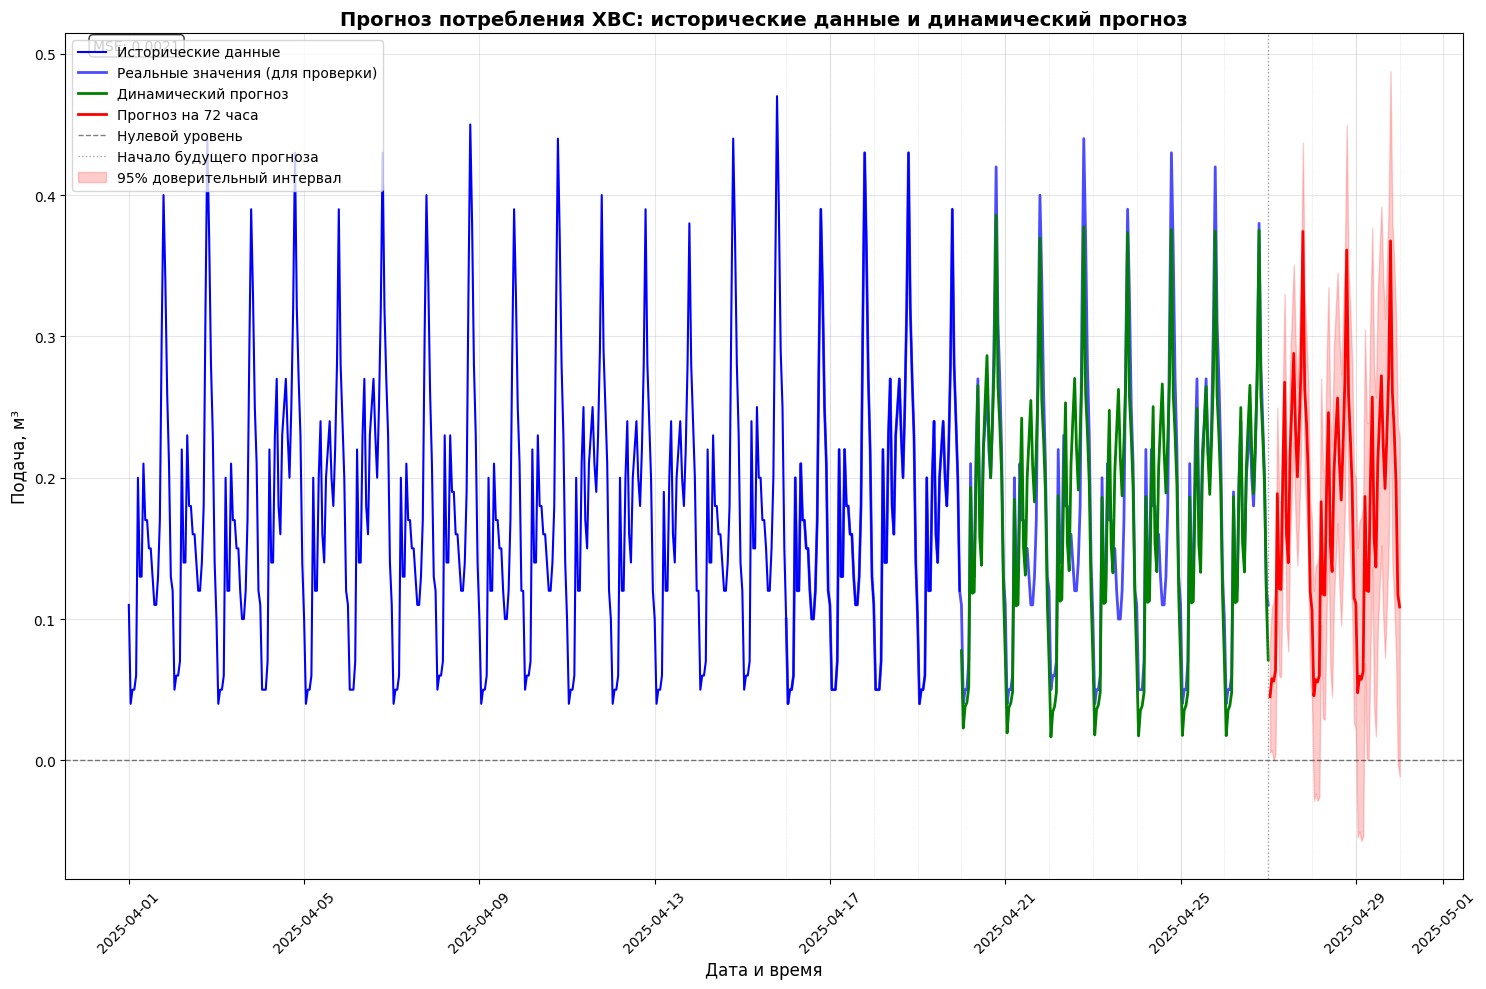


📊 ДЕТАЛИ ПРОГНОЗА:
   • Период валидации: 2025-04-16 00:00:00 - 2025-04-27 00:00:00
   • Начало прогноза: 2025-04-20 00:00:00
   • Будущий прогноз: 2025-04-27 01:00:00 - 2025-04-30 00:00:00
   • MSE: 0.0021

📈 ПЕРВЫЕ 10 ЗНАЧЕНИЙ ПРОГНОЗА:
   2025-04-27 01:00: 0.045 м³
   2025-04-27 02:00: 0.058 м³
   2025-04-27 03:00: 0.056 м³
   2025-04-27 04:00: 0.063 м³
   2025-04-27 05:00: 0.189 м³
   2025-04-27 06:00: 0.122 м³
   2025-04-27 07:00: 0.121 м³
   2025-04-27 08:00: 0.201 м³
   2025-04-27 09:00: 0.268 м³
   2025-04-27 10:00: 0.160 м³


In [21]:
# ПОСТРОЕНИЕ ГРАФИКА
plt.figure(figsize=(15, 10))

# 1. ИСТОРИЧЕСКИЕ ДАННЫЕ (до начала прогноза)
historical_data = gvs_time_series[:'2025-04-19 23:00:00']['ХВС Потребление за период, м3']
plt.plot(historical_data.index, historical_data, 
         label='Исторические данные', color='blue', linewidth=1.5)

# 2. РЕАЛЬНЫЕ ЗНАЧЕНИЯ (период валидации)
plt.plot(actual_values.index, actual_values, 
         label='Реальные значения (для проверки)', color='blue', linewidth=2, alpha=0.7)

# 3. ДИНАМИЧЕСКИЙ ПРОГНОЗ НА ИСТОРИЧЕСКИХ ДАННЫХ
plt.plot(dynamic_pred_values_hvs_potreb.index, dynamic_pred_values_hvs_potreb, 
         label='Динамический прогноз', color='green', linewidth=2)

# 4. ПРОГНОЗ НА БУДУЩЕЕ
future_dates = pd.date_range(start=actual_values.index[-1] + pd.Timedelta(hours=1), 
                            periods=72, freq='H')
plt.plot(future_dates, dynamic_forecast_values_hvs_potreb, 
         label='Прогноз на 72 часа', color='red', linewidth=2)

# 5. НУЛЕВАЯ ЛИНИЯ
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Нулевой уровень')

# 6. ЛИНИЯ РАЗДЕЛЕНИЯ МЕЖДУ ИСТОРИЕЙ И ПРОГНОЗОМ
split_date = actual_values.index[-1]
plt.axvline(x=split_date, color='gray', linestyle=':', linewidth=1, alpha=0.7, 
           label='Начало будущего прогноза')

# 7. ОБЛАСТЬ ДОВЕРИТЕЛЬНОГО ИНТЕРВАЛА (если есть)
try:
    conf_int = dynamic_forecast_hvs_potreb.conf_int()
    plt.fill_between(future_dates, 
                    conf_int.iloc[:, 0], 
                    conf_int.iloc[:, 1], 
                    color='red', alpha=0.2, 
                    label='95% доверительный интервал')
except:
    print("Доверительные интервалы недоступны")

# НАСТРОЙКА ГРАФИКА
plt.title('Прогноз потребления ХВС: исторические данные и динамический прогноз', 
          fontsize=14, fontweight='bold')
plt.xlabel('Дата и время', fontsize=12)
plt.ylabel('Подача, м³', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)

# ВЕРТИКАЛЬНЫЕ ЛИНИИ ДЛЯ РАЗДЕЛЕНИЯ СУТОК
for date in pd.date_range(start='2025-04-16', end=future_dates[-1], freq='D'):
    plt.axvline(x=date, color='gray', linestyle=':', linewidth=0.5, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()

# ДОБАВЛЕНИЕ ТЕКСТОВОЙ ИНФОРМАЦИИ НА ГРАФИК
plt.text(0.02, 0.98, f'MSE: {dyn_pred_hvs_potreb_mse:.4f}', 
         transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.show()


# ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ
print(f"\n📊 ДЕТАЛИ ПРОГНОЗА:")
print(f"   • Период валидации: {actual_values.index[0]} - {actual_values.index[-1]}")
print(f"   • Начало прогноза: {dynamic_pred_values_hvs_potreb.index[0]}")
print(f"   • Будущий прогноз: {future_dates[0]} - {future_dates[-1]}")
print(f"   • MSE: {dyn_pred_hvs_potreb_mse:.4f}")

# ВЫВОД ПЕРВЫХ 10 ЗНАЧЕНИЙ ПРОГНОЗА
print(f"\n📈 ПЕРВЫЕ 10 ЗНАЧЕНИЙ ПРОГНОЗА:")
for i, (date, value) in enumerate(zip(future_dates[:10], dynamic_forecast_values_hvs_potreb[:10])):
    print(f"   {date.strftime('%Y-%m-%d %H:%M')}: {value:.3f} м³")